In [1]:
# It allows to import files in the upper directory.
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import ai.data_set as ds
from ai.neural_network import create_model, format_data_set, get_inputs_real_outputs
from ai.evaluation import errors

%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def no_bm_bm_order(data_set_no_bm, data_set_bm):
    """
    Built the data set following the NoBM BM order. In this order, the data set first contains subgrids whose the middle tile does not contain a bomb
    and then contains the subgrids whose the middle tile contains a bomb.
    Data set format: ['no_bm_sg', 'no_bm_sg', ..., 'bm_sg', 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the NoBM BM order.
    """
    
    data_set = data_set_no_bm.copy()
    data_set.extend(data_set_bm)
    
    return data_set

def bm_no_bm_order(data_set_no_bm, data_set_bm):
    """
    Built the data set following the BM NoBM order. In this order, the data set first contains the subgrids whose the middle tile contains a bomb
    and then contains subgrids whose the middle tile does not contain a bomb.
    Data set format: ['bm_sg', 'bm_sg', ..., 'no_bm_sg', 'no_bm_sg', ...], where 'bm_sg' is a subgrid whose the middle tile contains a bomb
    and 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the BM NoBM order.
    """
    
    data_set = data_set_bm.copy()
    data_set.extend(data_set_no_bm)
    
    return data_set

def alternaten_order(data_set_no_bm, data_set_bm, n):
    """
    Built the data set following the Alternate N order. In this order, the data set alternates between 'n' subgrids whose the middle tile does not contain a bomb
    and 'n' subgrids whose the middle tile contains a bomb.
    Data set format: ['n' * no_bm_sg', 'n' * 'bm_sg', 'n' * no_bm_sg', 'n' * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :n: The batch of subgrids to alternate.
    :return: The data set following the Alternate N order.
    """
    
    min_num_subgrids = min(len(data_set_no_bm), len(data_set_bm))
    
    data_set_no_bm_gen = iter(data_set_no_bm)
    data_set_bm_gen = iter(data_set_bm)
    
    data_set = []    
    for i in range(int(min_num_subgrids / n)):
        data_set.extend([next(data_set_no_bm_gen) for j in range(n)])
        data_set.extend([next(data_set_bm_gen) for j in range(n)])
    
    return data_set

def alternate1_order(data_set_no_bm, data_set_bm):
    """
    Built the data set following the Alternate 1 order. In this order, the data set alternates between 1 subgrid whose the middle tile does not contain a bomb
    and 1 subgrid whose the middle tile contains a bomb.
    Data set format: [1 * 'no_bm_sg', 1 * 'bm_sg', 1 * 'no_bm_sg', 1 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 1 order.
    """
    
    return alternaten_order(data_set_no_bm, data_set_bm, 1)

def alternate5_order(data_set_no_bm, data_set_bm):
    """
    Built the data set following the Alternate 1 order. In this order, the data set alternates between 5 subgrids whose the middle tile does not contain a bomb
    and 5 subgrids whose the middle tile contains a bomb.
    Data set format: [5 * 'no_bm_sg', 5 * 'bm_sg', 5 * 'no_bm_sg', 5 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 5 order.
    """
    
    return alternaten_order(data_set_no_bm, data_set_bm, 5)

def alternate10_order(data_set_no_bm, data_set_bm):
    """
    Built the data set following the Alternate 10 order. In this order, the data set alternates between 10 subgrids whose the middle tile does not contain a bomb
    and 10 subgrids whose the middle tile contains a bomb.
    Data set format: [10 * 'no_bm_sg', 10 * 'bm_sg', 10 * 'no_bm_sg', 10 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 10 order.
    """
    
    return alternaten_order(data_set_no_bm, data_set_bm, 10)

def alternate15_order(data_set_no_bm, data_set_bm):
    """
    Built the data set following the Alternate 1 order. In this order, the data set alternates between 15 subgrids whose the middle tile does not contain a bomb
    and 15 subgrids whose the middle tile contains a bomb.
    Data set format: [15 * 'no_bm_sg', 15 * 'bm_sg', 15 * 'no_bm_sg', 15 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 15 order.
    """
    
    return alternaten_order(data_set_no_bm, data_set_bm, 15)

def random_order(data_set_no_bm, data_set_bm):
    """
    Built the data set following the Random order. In this order, the ordre of the data set is random.
    
    :data_set_no_bm: A formatted data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm: A formatted data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Random order.
    """
    
    data_set = data_set_no_bm.copy()
    data_set.extend(data_set_bm)
    
    random.shuffle(data_set)
    
    return data_set

order_dic = {"NoBM BM": no_bm_bm_order, "BM NoBM": bm_no_bm_order, "Alternate 1": alternate1_order, "Alternate 5": alternate5_order,
             "Alternate 10": alternate10_order, "Alternate 15": alternate15_order, "Random": random_order}

In [4]:
seed = 42

radius_subgrids = 2
num_tiles_subgrids = ((radius_subgrids * 2) + 1) ** 2
num_rows_grid = 10
num_columns_grid = 10
num_bombs_grid = 10
num_no_bm_subgrids = 50000
num_bm_subgrids = 50000
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.
num_masked_subgrids = 10

ds_no_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, False)
ds_no_bm_file_name = ds_no_bm_file_name[3:]
ds_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, True)
ds_bm_file_name = ds_bm_file_name[3:]
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

random.seed(seed)
np.random.seed(int(seed)) # Makes Keras deterministic.
tf.set_random_seed(seed) # Makes TensorFlow deterministic.

# Training set.
print("Training set.")
data_set_gen = ds.read_data_set(ds_no_bm_file_name)
training_set_no_bm = [next(data_set_gen) for i in range(num_no_bm_subgrids)]

data_set_gen = ds.read_data_set(ds_bm_file_name)
training_set_bm = [next(data_set_gen) for i in range(num_bm_subgrids)]
print("Data set loaded.")

# Format the training set.
training_set_no_bm = format_data_set(training_set_no_bm, num_masked_subgrids)
training_set_bm = format_data_set(training_set_bm, num_masked_subgrids)
print("Training set formatted.\n")

# Test set.
print("Test set.")
data_set_gen = ds.read_data_set(ds_no_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set = [next(data_set_gen) for i in range(5000)]

data_set_gen = ds.read_data_set(ds_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set.extend([next(data_set_gen) for i in range(5000)])
print("Data set loaded.")

# Format the test set.
test_set = format_data_set(test_set, num_masked_subgrids)
print("Test set formatted.")

# Get the 'x' and 'y_true' vectors.
x_test, y_true_test = get_inputs_real_outputs(test_set)
print("Inputs and real outputs extracted.\n")

orders_to_take = ["NoBM BM", "BM NoBM", "Alternate 1", "Alternate 5", "Alternate 10", "Alternate 15", "Random"]
orders = {order: order_dic[order] for order in orders_to_take if order in order_dic}
err_list = []
for order_name, order in orders.items():
    print("{} order.".format(order_name))
    
    # Load the data set.
    training_set = order(training_set_no_bm, training_set_bm)
    print("Data set loaded.")
    
    # Get the 'x' and 'y_true' vectors.
    x_training, y_true_training = get_inputs_real_outputs(training_set)
    print("Inputs and real outputs extracted.")

    # Create the model.
    model = create_model(num_tiles_subgrids)
    
    # Train the model.
    model.fit(x_training, y_true_training, epochs=1, batch_size=10)
    print("Neural network trained.")
    
    # Prediction and errors.
    y_pred = model.predict(x_test)
    y_pred = [y_p[0] for y_p in y_pred]

    # Errors
    error_func = lambda y_t, y_p: abs(y_t - y_p)
    err = errors(y_true_test, y_pred, error_func)
    print("Errors computed.")

    err_list.append(err)
    
    print('')

Training set.
Data set loaded.
Training set formatted.

Test set.
Data set loaded.
Test set formatted.
Inputs and real outputs extracted.

NoBM BM order.
Data set loaded.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 129s 129us/step - loss: 0.1047 - mean_squared_error: 0.1047 - mean_absolute_error: 0.1918 - acc: 0.8507
Neural network trained.
Errors computed.

BM NoBM order.
Data set loaded.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 128s 128us/step - loss: 0.1047 - mean_squared_error: 0.1047 - mean_absolute_error: 0.1925 - acc: 0.8503
Neural network trained.
Errors computed.

Alternate 1 order.
Data set loaded.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 128s 128us/step - loss: 0.1046 - mean_squared_error: 0.1046 - mean_absolute_error: 0.1928 - acc: 0.8507
Neural network trained.
Errors computed.

Alternate 5 order.
Data set loaded.

In [5]:
opacity = 1
color = '#FED487'
edge_color = 'black'
mean_color = 'orange'
percentile_25_color = 'limegreen'
median_color = 'red'
percentile_75_color = 'limegreen'
dot_color = 'black'

save_fig = True
fig_format = 'png'
fig_dpi = 500

<IPython.core.display.Javascript object>


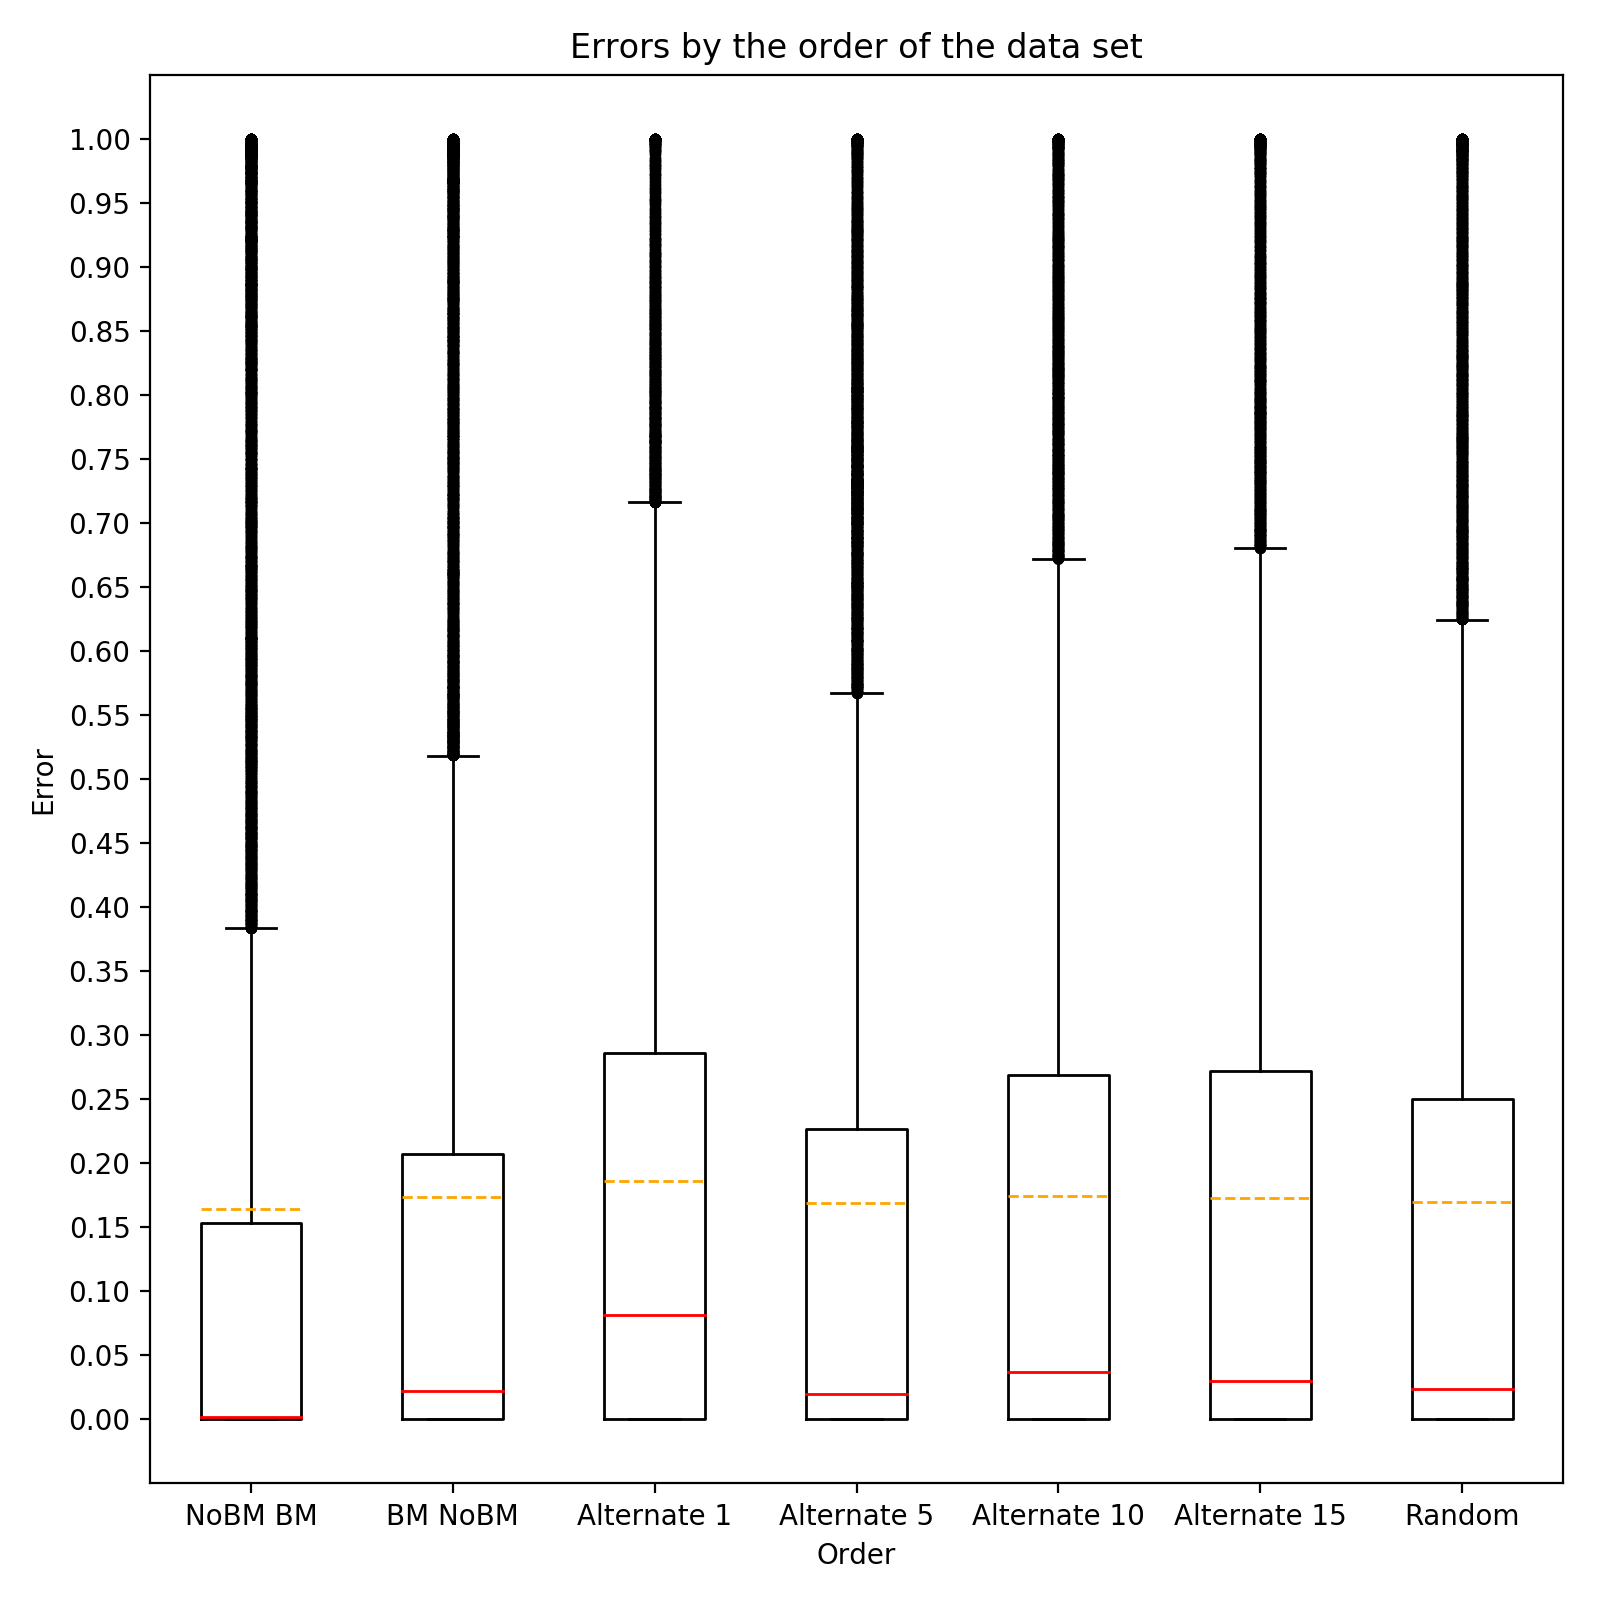

In [6]:
# Box plot of errors by the number of subgrids.

fig = plt.figure(figsize=(8, 8))
bplot = plt.boxplot(err_list, showmeans=True, meanline=True, sym='.')
plt.xticks(range(1, len(orders) + 1), orders.keys())
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors by the order of the data set')
plt.xlabel('Order')
plt.ylabel('Error')
plt.setp(bplot['means'], color=mean_color)
plt.setp(bplot['medians'], color=median_color)
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig(('errors_by_dataset_order.' + fig_format), format=fig_format, dpi=fig_dpi)